# Exercise Sheet 5 - Variational Autoencoders

- Deep Learning for Computer Vision - Winter Term 2024/25
- Lecture by: Constantin Pape
- Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
- Due date: **Tuesday, Jan 14, before 10:00**

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook and **rename** it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (.ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 5` -> `Tutorial X` (where, X is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train and test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [1]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Python 3.10.12
2.4.1+cu121


### Basic setup

Define various global parameters used throughout the notebook!

In [2]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Define beta (weighting of regularization loss)
beta = 1

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 640x480 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [3]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')

elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')

else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')

Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [4]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

#Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(), #Converts images to PyTorch tensors.
    transforms.Normalize((0.5,), (0.5,)) #Normalize images to [-1, 1]  
])

# TODO: Load the datasets
train_dataset = datasets.FashionMNIST(
    root = data_dir, 
    train = True,
    download = True,
    transform = transform #Make sure the transform is passed here
)

test_dataset = datasets.FashionMNIST(
    root = data_dir,
    train = False, 
    download = True, 
    transform = transform #Make sure the transform is passed here. 
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14066961.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208205.24it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3944547.31it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8849293.85it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [5]:
# TODO: Define the data loaders
train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

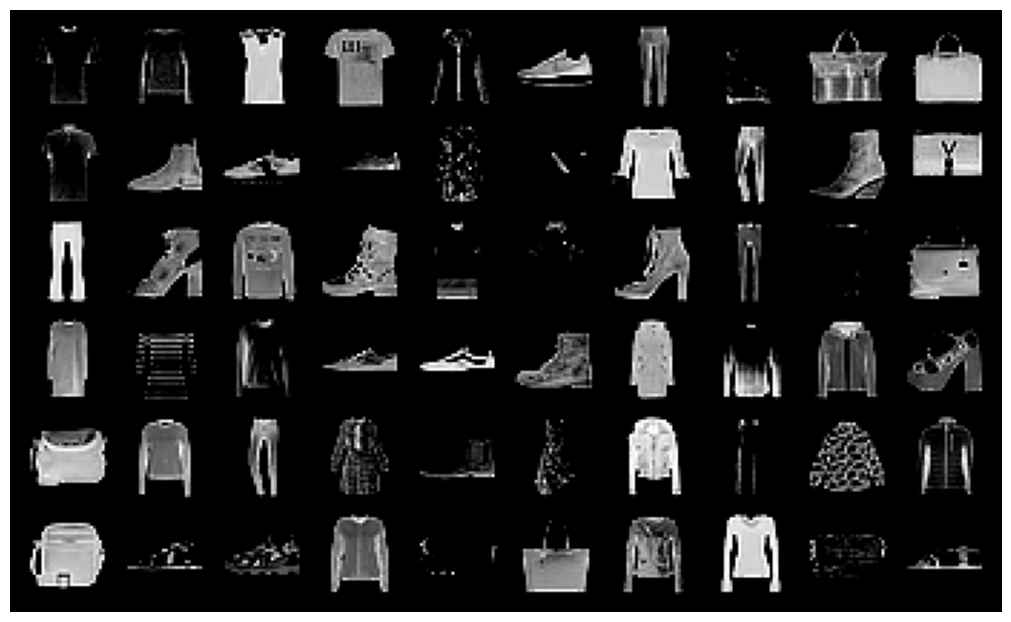

In [6]:
images_columns = 10
images_rows = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

## Implement a VAE neural network architecture

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, σ²)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance. 

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

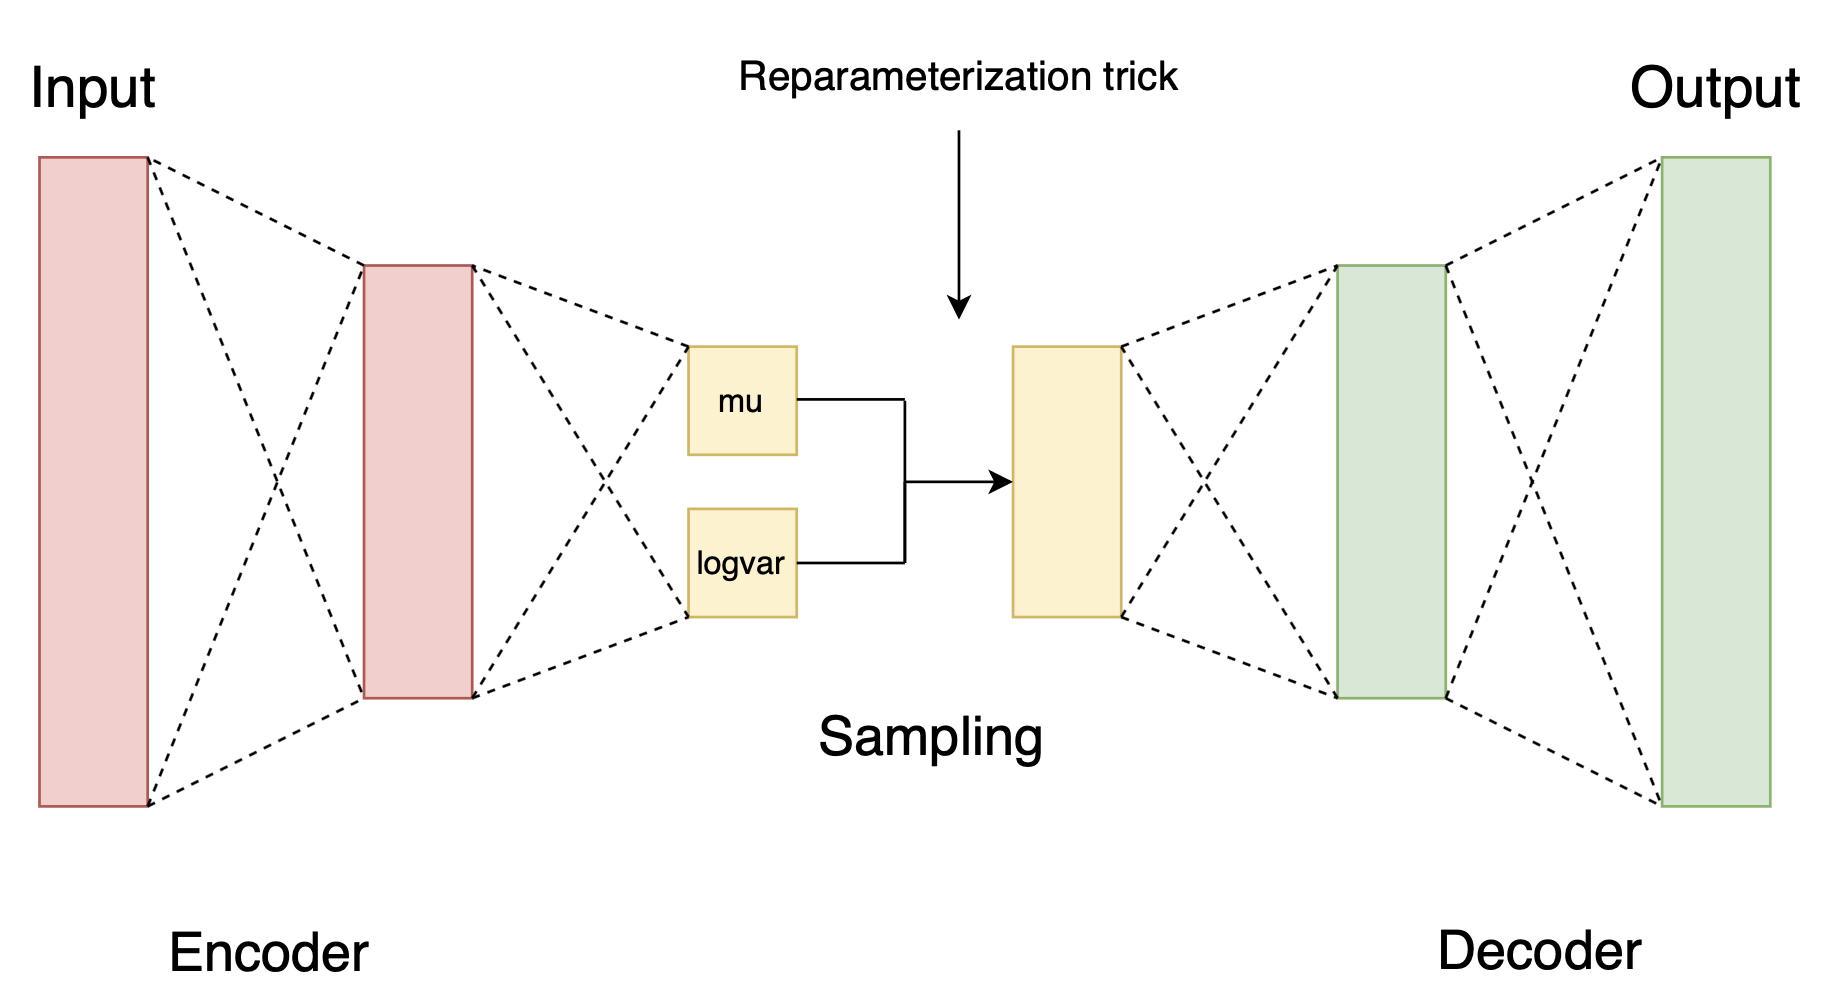

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly: 

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 
**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each 
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the trick do and why do we need it?

**Your answer here:**

Direct sampling from Z ~ N(μ, σ²) is not differentiable. Thus, the reparameterization trick separates the stochastic sampling (via $\epsilon$) from the learned parameters μ and σ. It makes the sampling process differentiable, enabling gradient based optmization (eg. SGD, Adam) to flow throug the network and work properly; thus enabling gradient descent. 

In [7]:
# TODO Implement the VAE
class VAE(nn.Module):
    def __init__(self, capacity, latent_dims):
        super(VAE, self).__init__()
        self.capacity = capacity
        self.latent_dims = latent_dims

        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, capacity, kernel_size = 4, stride = 2, padding = 1), #(1, 28, 28) -> (capacity, 14, 14)
            nn.ReLU(),
            nn.Conv2d(capacity, 2 * capacity, kernel_size = 4, stride = 2, padding = 1), #(capacity, 14, 14) -> (2 * capacity, 7, 7)
            nn.ReLU()
        )

        #Sampling layers
        self.fc_mu = nn.Linear(2 * capacity * 7 * 7, latent_dims) #Mean
        self.fc_logvar = nn.Linear(2 * capacity * 7 * 7, latent_dims) #Log variance
        self.fc_z = nn.Linear(latent_dims, 2 * capacity * 7 * 7)  # Latent -> Intermediate


        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2 * capacity, capacity, kernel_size = 4, stride = 2, padding = 1), #(2*capacity, 7, 7) -> (capacity, 14, 14)
            nn.ReLU(), 
            nn.ConvTranspose2d(capacity, 1, kernel_size = 4, stride = 2, padding = 1), #(capacity, 14, 14) -> (1, 28, 28)
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """
        Reparamertization Trick: z = mu + std * epsilon
        """
        if self.training:
            std = torch.exp(0.5 * logvar) #Standard deviation
            epsilon = torch.randn_like(std) #Random noise
            return mu + std * epsilon
        else:
            return mu #User mean during evaluation

    def forward(self, x):
        """
        Forward pass through the VAE
        """
        #Encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1) #Flatten

        #Sampling
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize (mu, logvar)

        #Decoding
        x = self.fc_z(z)
        x = x.view(-1, 2 * self.capacity, 7, 7) #Reshape for ConvTranspose2d
        x = self.decoder(x)

        return x, mu, logvar

    def decode(self, z):
        """Decode from the latent space to the image space"""
        x = self.fc_z(z)
        x = x.view(-1, 2 * self.capacity, 7, 7) #Reshape for ConvTranspose2d
        x = self.decoder(x)
        return x

#Instantiate the model
vae = VAE(capacity = capacity, latent_dims = latent_space_dim)
print(vae)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)


**Hint:** 
- Make sure that you use sum instead of mean for calculating the MSE loss!
- Refer to the paper _Auto-Encoding Variational Bayes_ by Kingma and Welling to implement the loss function. 

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

In [8]:

def vae_loss(recon_x, x, mu, logvar, beta = 1.0):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    """
    Parameters: 
    - recon_x = reconstucted output from the decoder (batch_size, channel, height, width)
    - x = Oirginal input image
    - mu = mean vector from the encoder
    - logvar = log-variance vector from the encoder 
    
    """
    mse_loss = F.mse_loss(recon_x, x, reduction = 'sum')  # TODO

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114

    # Formula: KL = -0.5 * Σ(1 + log(σ^2) - μ^2 - σ^2)
    kld_loss =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # TODO

    total_loss = mse_loss + beta * kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [9]:
model = VAE(capacity = capacity, latent_dims = latent_space_dim) # TODO
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)# TODO

In [10]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot using the given `plot_losses` function**


In [11]:
from tqdm import tqdm

def train(model, train_loader, optimizer, epoch, device, exp_average_factor = 0.95):
    model.train()
    train_total_losses = []
    train_mse_losses = []
    train_kld_losses = []

    #Initialize the EMA variables. 
    ema_total_loss = None
    ema_mse_loss = None
    ema_kld_loss = None

    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        loss, mse_loss, kld_loss = vae_loss(recon_batch, data, mu, logvar, beta = 1.0)
        optimizer.zero_grad()
        loss.backward()
        
        # Optimize
        optimizer.step()

         # Apply EMA for smoothing
        if ema_total_loss is None:
            ema_total_loss = loss.item()
            ema_mse_loss = mse_loss.item()
            ema_kld_loss = kld_loss.item()
        else:
            ema_total_loss = exp_average_factor * ema_total_loss + (1 - exp_average_factor) * loss.item()
            ema_mse_loss = exp_average_factor * ema_mse_loss + (1 - exp_average_factor) * mse_loss.item()
            ema_kld_loss = exp_average_factor * ema_kld_loss + (1 - exp_average_factor) * kld_loss.item()
            
        
        # Log batch losses
        train_total_losses.append(ema_total_loss)
        train_mse_losses.append(ema_mse_loss)
        train_kld_losses.append(ema_kld_loss)
    
    return train_total_losses, train_mse_losses, train_kld_losses



In [12]:
def test(model, test_loader, device):
    model.eval()
    test_total_losses = []
    test_mse_losses = []
    test_kld_losses = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc="Testing"):
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Compute loss
            loss, mse_loss, kld_loss = vae_loss(recon_batch, data, mu, logvar, beta = 1.0)
            
            # Log batch losses
            test_total_losses.append(loss.item())
            test_mse_losses.append(mse_loss.item())
            test_kld_losses.append(kld_loss.item())
    
    return test_total_losses, test_mse_losses, test_kld_losses

In [13]:
# Instantiate the model and optimizer
model = VAE(capacity=capacity, latent_dims=latent_space_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Track training and testing losses
train_total_losses = []
train_mse_losses = []
train_kld_losses = []

test_total_losses = []
test_mse_losses = []
test_kld_losses = []

# Loop through epochs
for epoch in range(1, epochs + 1):
    # Train the model
    epoch_train_total, epoch_train_mse, epoch_train_kld = train(
        model, train_loader, optimizer, epoch, device
    )
    train_total_losses.extend(epoch_train_total)
    train_mse_losses.extend(epoch_train_mse)
    train_kld_losses.extend(epoch_train_kld)
    
    # Test the model (batch-level losses)
    epoch_test_total, epoch_test_mse, epoch_test_kld = test(
        model, test_loader, device
    )
    test_total_losses.extend(epoch_test_total)
    test_mse_losses.extend(epoch_test_mse)
    test_kld_losses.extend(epoch_test_kld)


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.69it/s]


In [14]:
def plot_losses(
    train_total_losses=None, train_mse_losses=None, train_kld_losses=None, 
    test_epoch_total_losses=None, test_epoch_mse_losses=None, test_epoch_kld_losses=None
):
    x = range(1, len(train_total_losses) + 1)
    train_batches = len(train_loader)

    # set line colors
    train_color_mse   = 'moccasin'
    train_color_kld   = 'skyblue'
    train_color_total = 'palegreen'

    test_color_mse   = 'orange'
    test_color_kld   = 'blue'
    test_color_total = 'green'

    # create figure
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 8)

    # Create total / mse loss axis
    ax1.set_xlabel("Batches (Epoch)")
    ax1.set_ylabel("Total / MSE loss")
    ax1.grid(visible=True, axis='x', linestyle=':')
    ax1.set_xticks(np.arange(0, epochs * train_batches, train_batches))
    labels = [f'{str(item)} ({index})' for index, item in enumerate(ax1.get_xticks().tolist())]
    ax1.set_xticklabels(labels)

    # Plot train-set losses
    ax1.plot(x, train_mse_losses, label="Train reconstruction loss (MSE)", color=train_color_mse)
    ax1.plot(np.nan, label = 'Train regularization loss (KLD)', color=train_color_kld) # add legend entry for KLD
    ax1.plot(x, train_total_losses, label="Train total loss", color=train_color_total)

    # Compute test-set epoch average losses
    test_total_losses=[]; test_mse_losses=[]; test_kld_losses=[]
    for epoch in range(epochs):
        test_total_losses += [test_epoch_total_losses[epoch] for i in range(train_batches)]
        test_mse_losses   += [test_epoch_mse_losses[epoch] for i in range(train_batches)]
        test_kld_losses   += [test_epoch_kld_losses[epoch] for i in range(train_batches)]

    # Plot test-set losses
    ax1.plot(x, test_mse_losses, label="Test reconstruction loss (MSE)", color=test_color_mse)
    ax1.plot(np.nan, label = 'Test regularization loss (KLD)', color=test_color_kld) # add legend entry for KLD
    ax1.plot(x, test_total_losses, label="Test total loss", color=test_color_total)


    # Create kld loss twin axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("KLD loss")
    ax2.plot(x, train_kld_losses, label="Train regularization loss (KLD)", color=train_color_kld)
    ax2.plot(x, test_kld_losses, label="Test regularization loss (KLD)", color=test_color_kld)

    ax1.legend()

    fig.tight_layout() 
    plt.show()

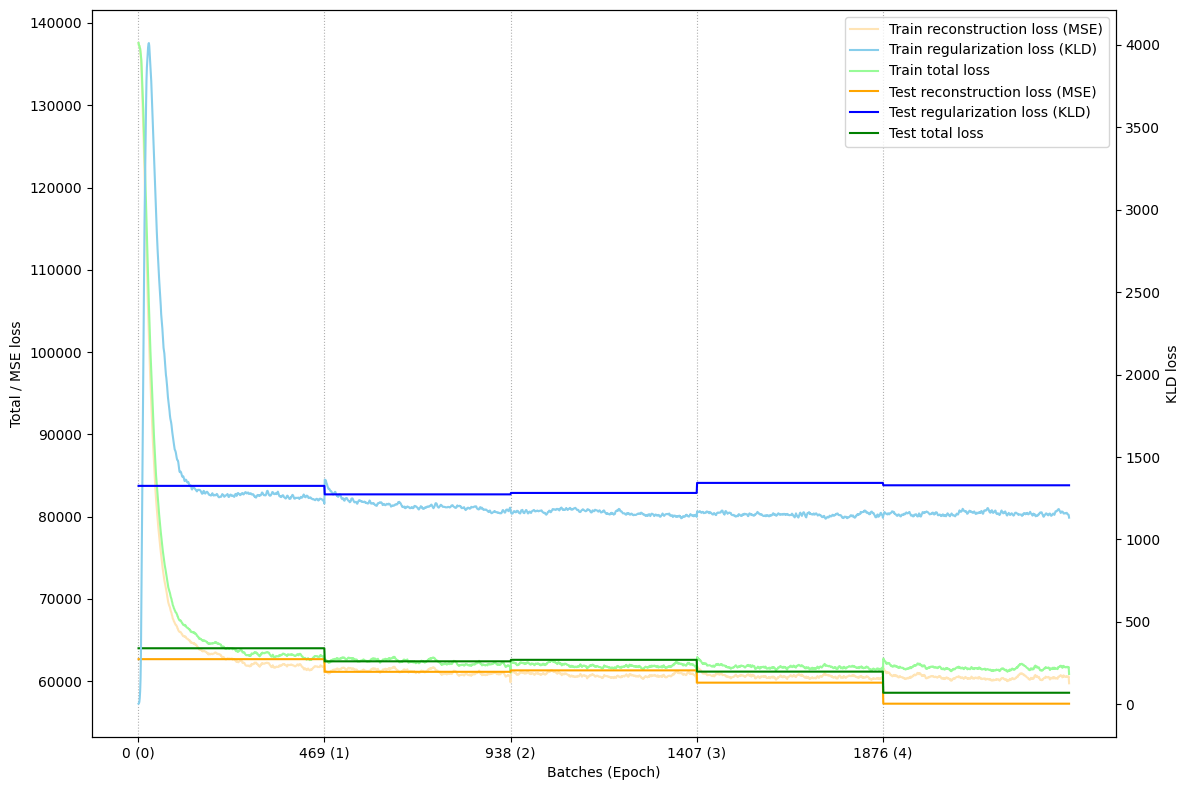

In [15]:
plot_losses(
    train_total_losses=train_total_losses, 
    train_mse_losses=train_mse_losses, 
    train_kld_losses=train_kld_losses,
    test_epoch_total_losses=test_total_losses, 
    test_epoch_mse_losses=test_mse_losses, 
    test_epoch_kld_losses=test_kld_losses,
)


### Visualization of random samples from the latent space via decoding

Here we just create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

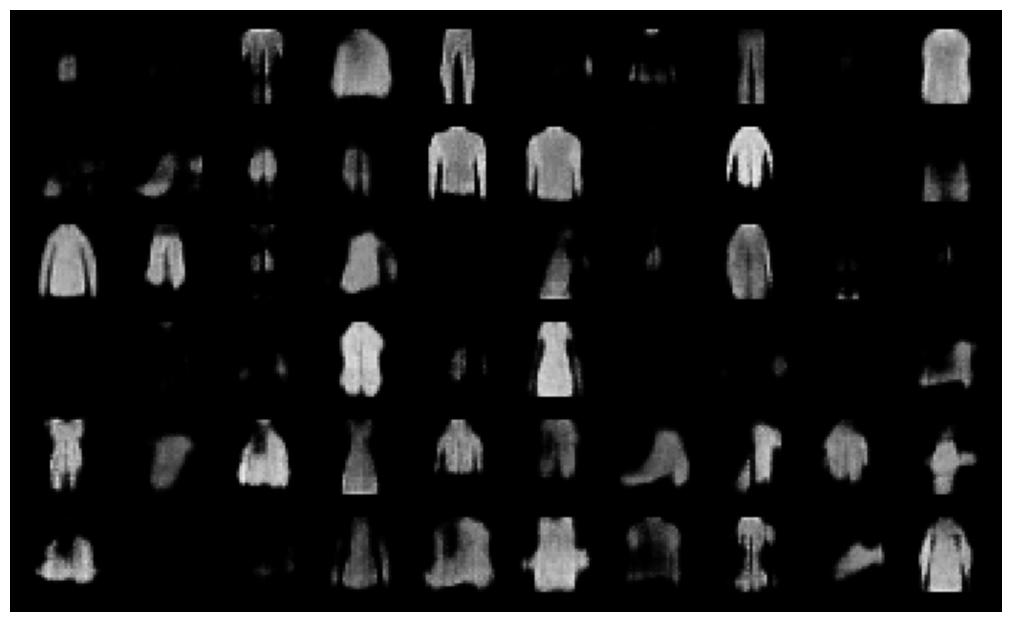

In [16]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_space_dim).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

Original Images


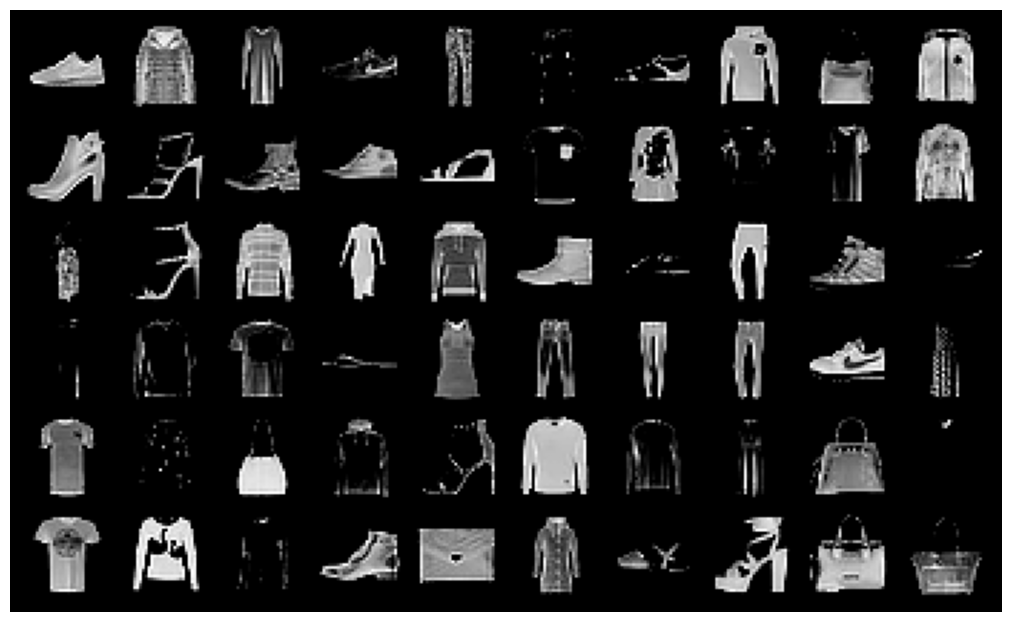

Reconstructed Images


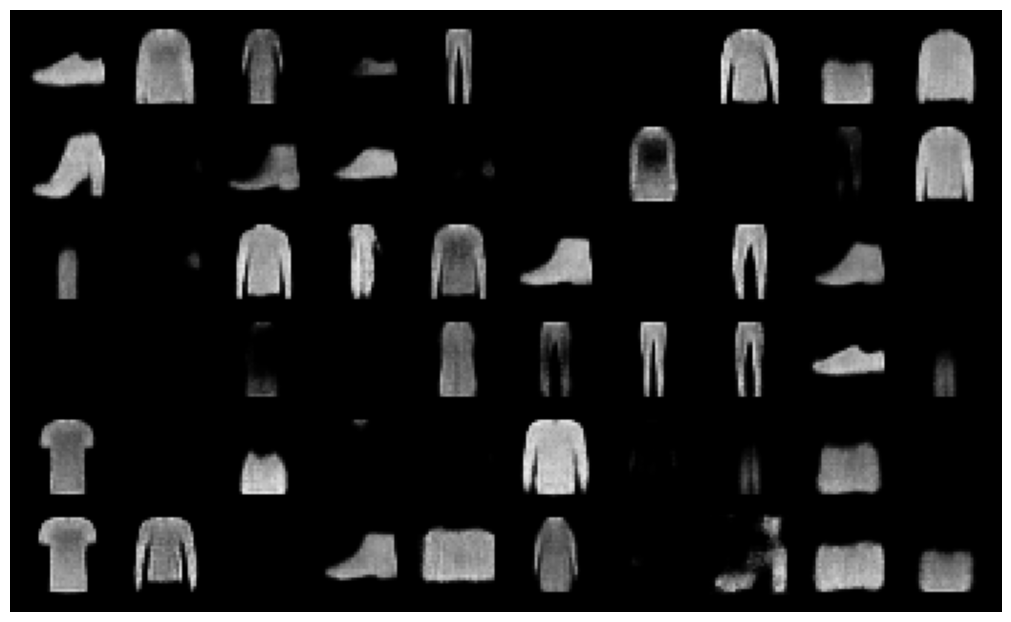

In [17]:
# Parameters for grid display
images_columns = 10
images_rows = 6

# Fetch a batch of images from the training loader
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Show original images
print("Original Images")
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():
    # Move images to device (GPU/CPU)
    images = images.to(device)
    
    # Pass images through the VAE
    recon_images, mu, logvar = model(images)
    
    # Move reconstructed images to CPU for visualization
    recon_images = recon_images.cpu()
    
    print("Reconstructed Images")
    show_grid(recon_images[0:(images_columns * images_rows)], images_columns, images_rows)


### Optimization


How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses. 

**Answers**
Larger latent dimensionality generally has better reconstructions comparing to lower dimensions. However, it has potential risks of overfitting and higher test loss. Lower latent dimensionality generally has higher loss and low reconstruction quality. Thus, we should be able to find the best dimensions which has balanced reconstruction quality and lower loss. 

In our case, the best latent dimension was 16 at it has less errror and reconstruceted images were clear. 


🧪 Training VAE with Latent Dimension: 2


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.87it/s]



📊 Plotting Losses for Latent Dimension: 2


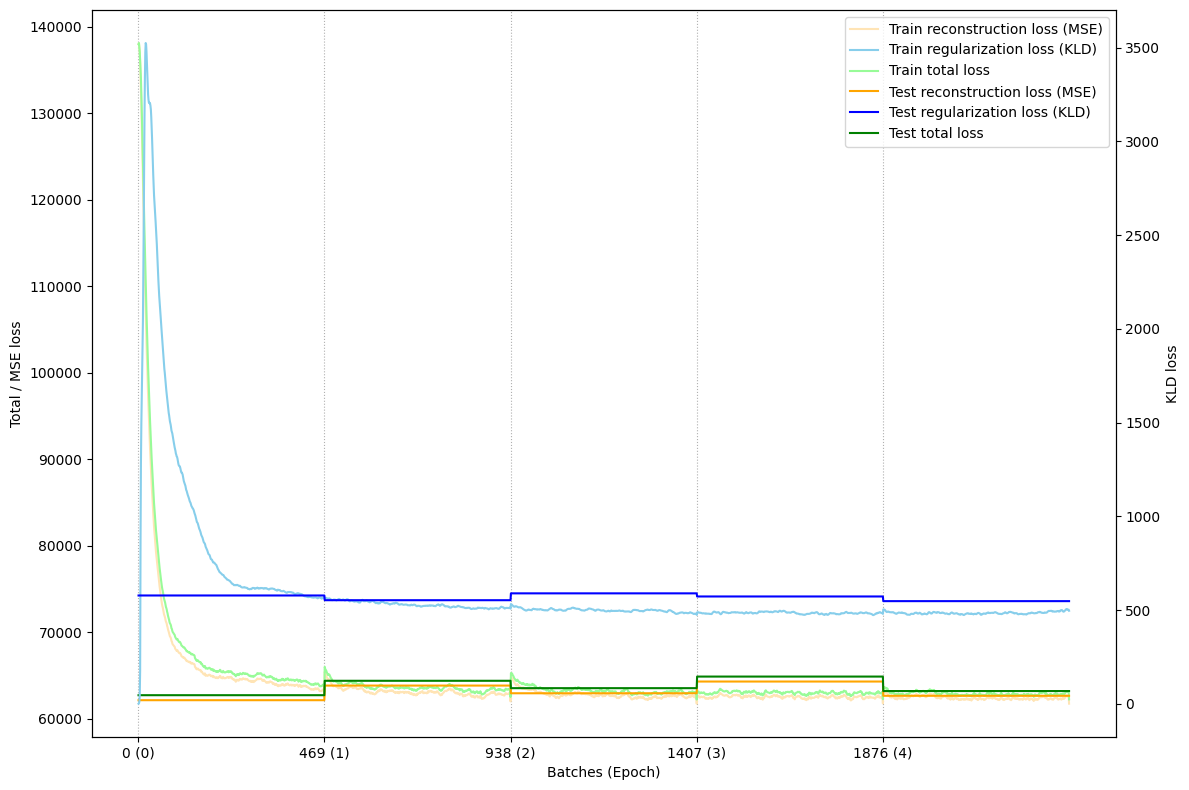


🖼️ Visualizing Reconstructions for Latent Dimension: 2
Original Images


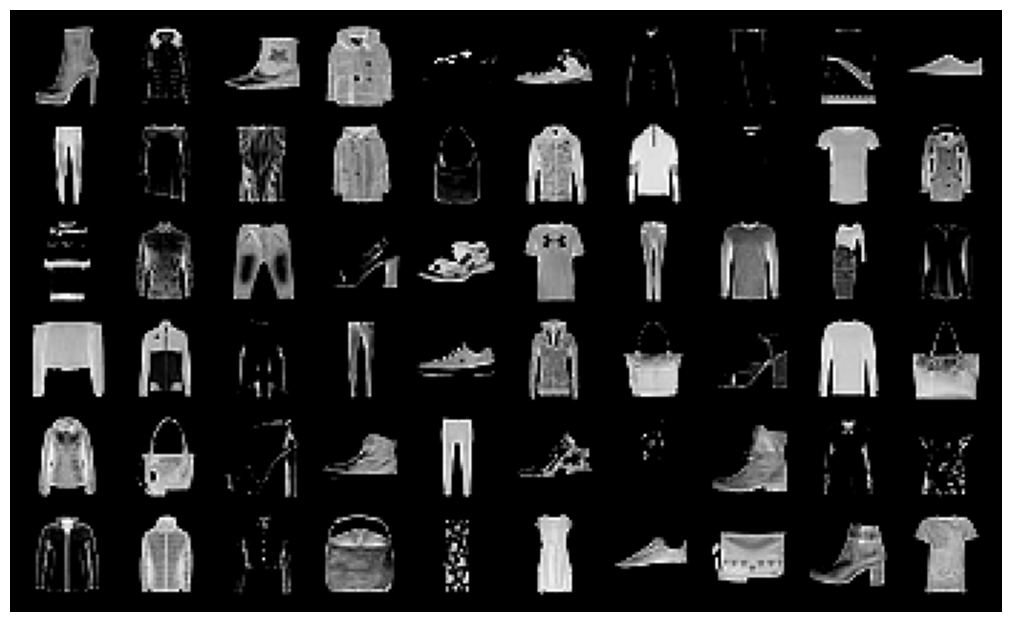

Reconstructed Images


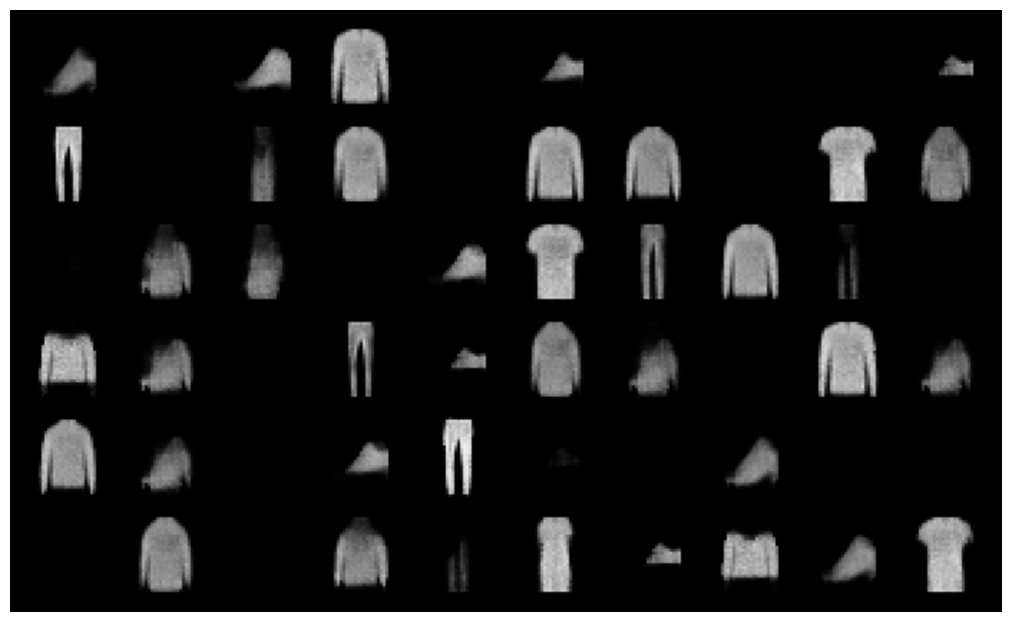


🧪 Training VAE with Latent Dimension: 4


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.32it/s]



📊 Plotting Losses for Latent Dimension: 4


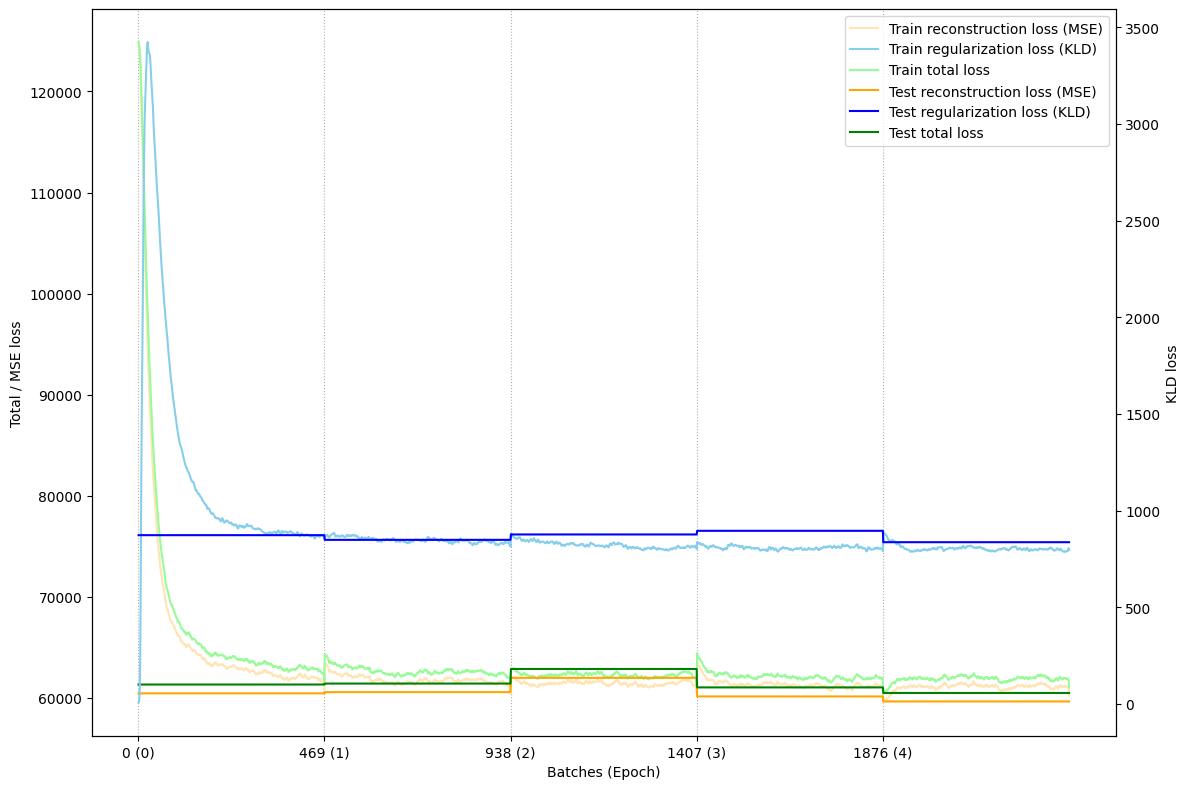


🖼️ Visualizing Reconstructions for Latent Dimension: 4
Original Images


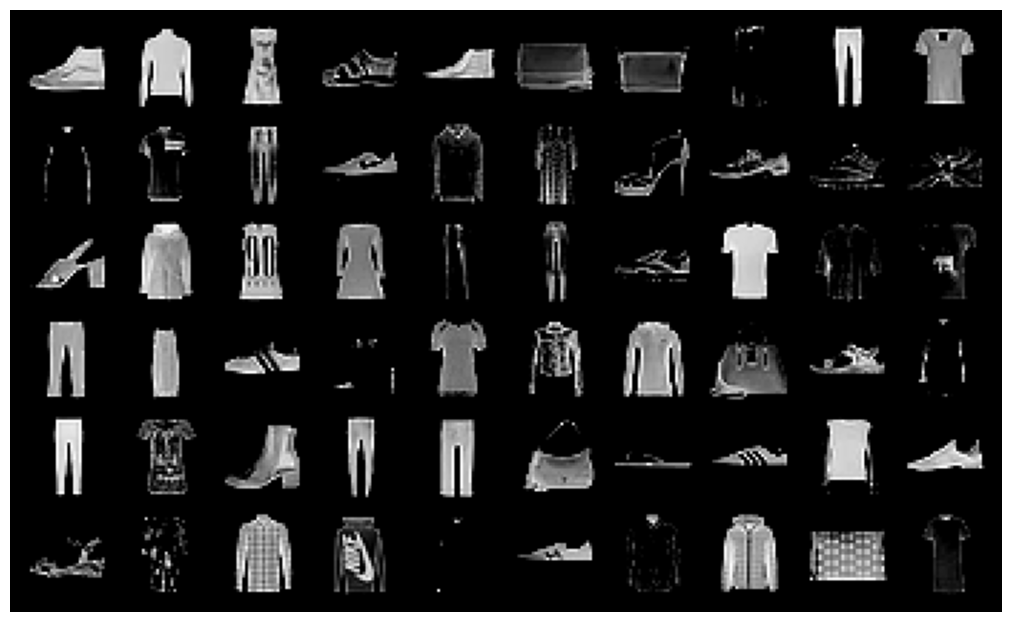

Reconstructed Images


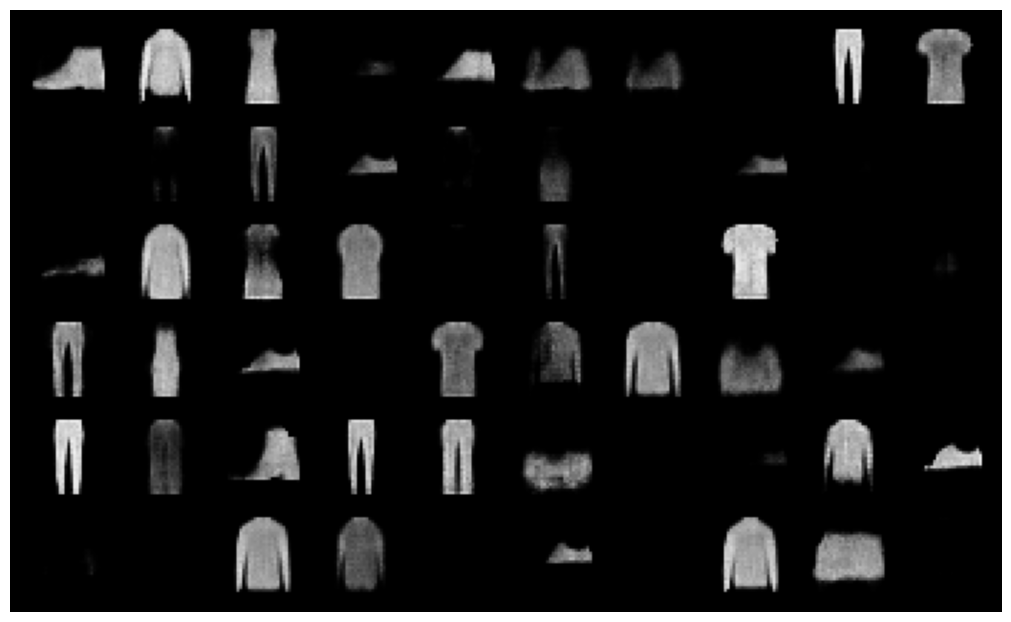


🧪 Training VAE with Latent Dimension: 8


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.80it/s]



📊 Plotting Losses for Latent Dimension: 8


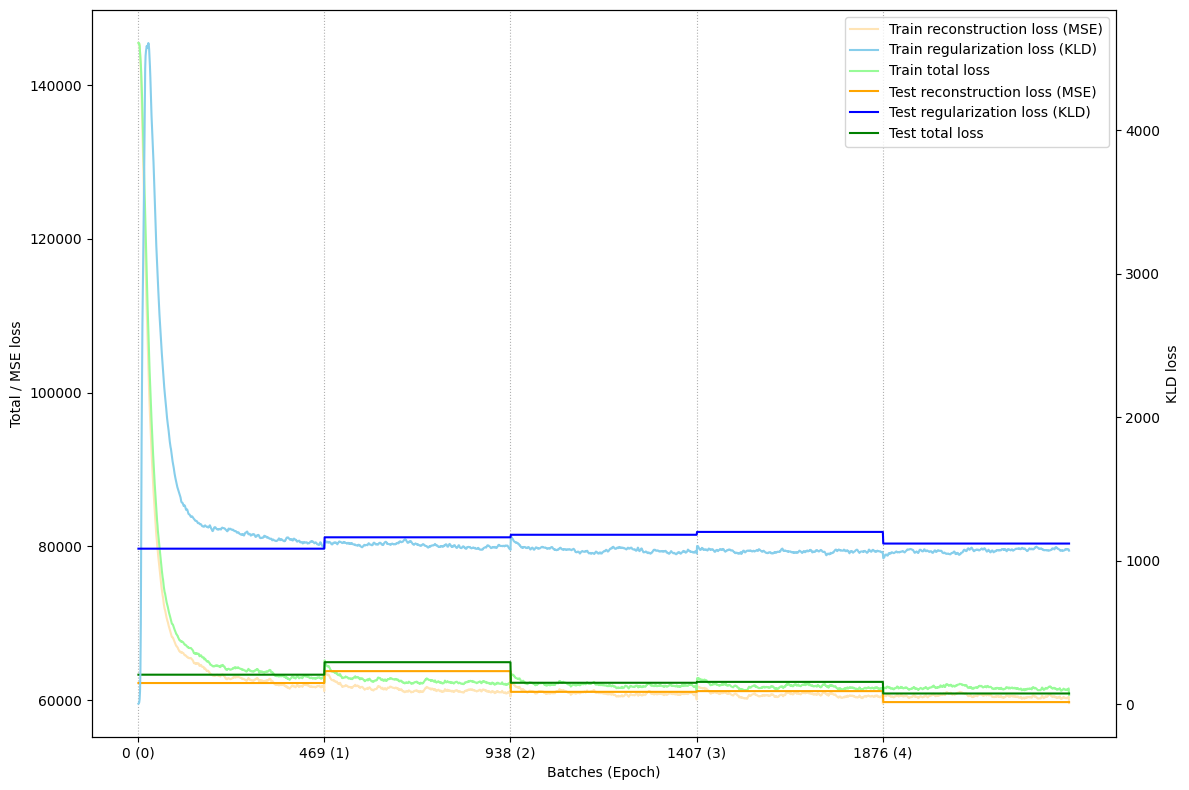


🖼️ Visualizing Reconstructions for Latent Dimension: 8
Original Images


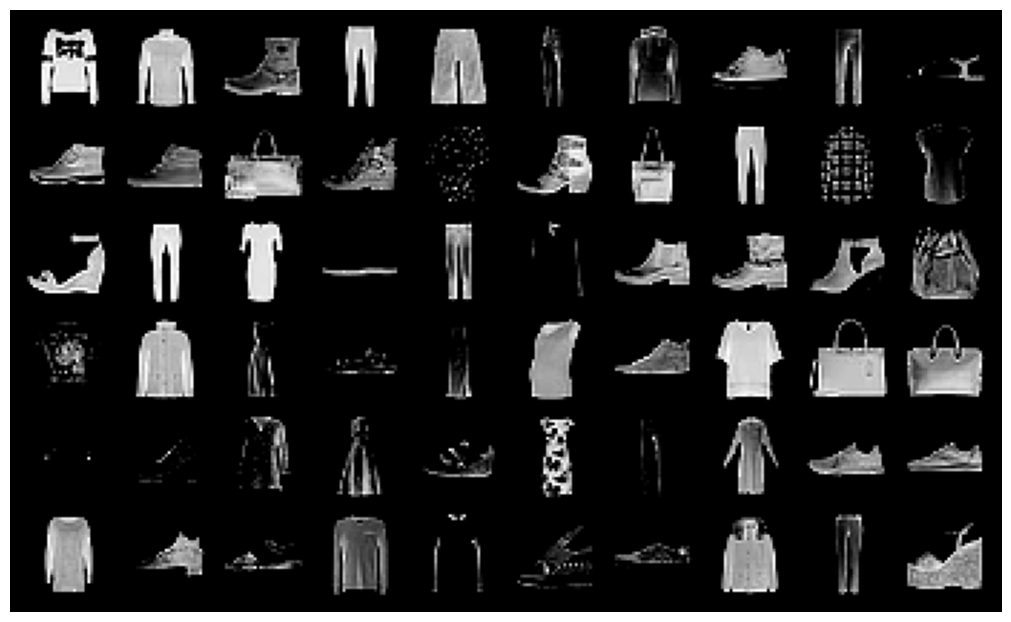

Reconstructed Images


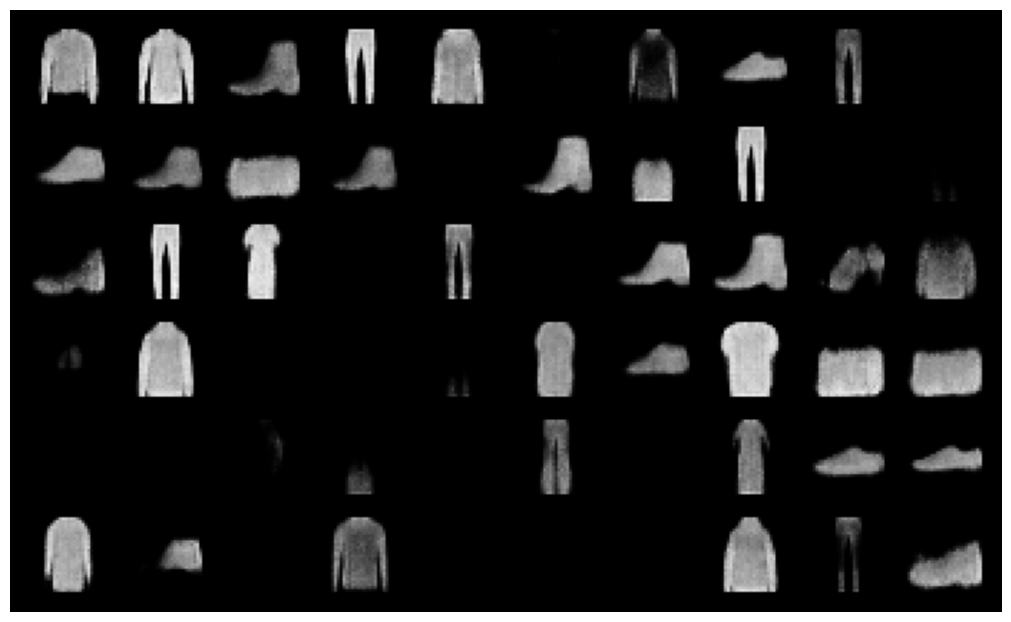


🧪 Training VAE with Latent Dimension: 16


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.55it/s]



📊 Plotting Losses for Latent Dimension: 16


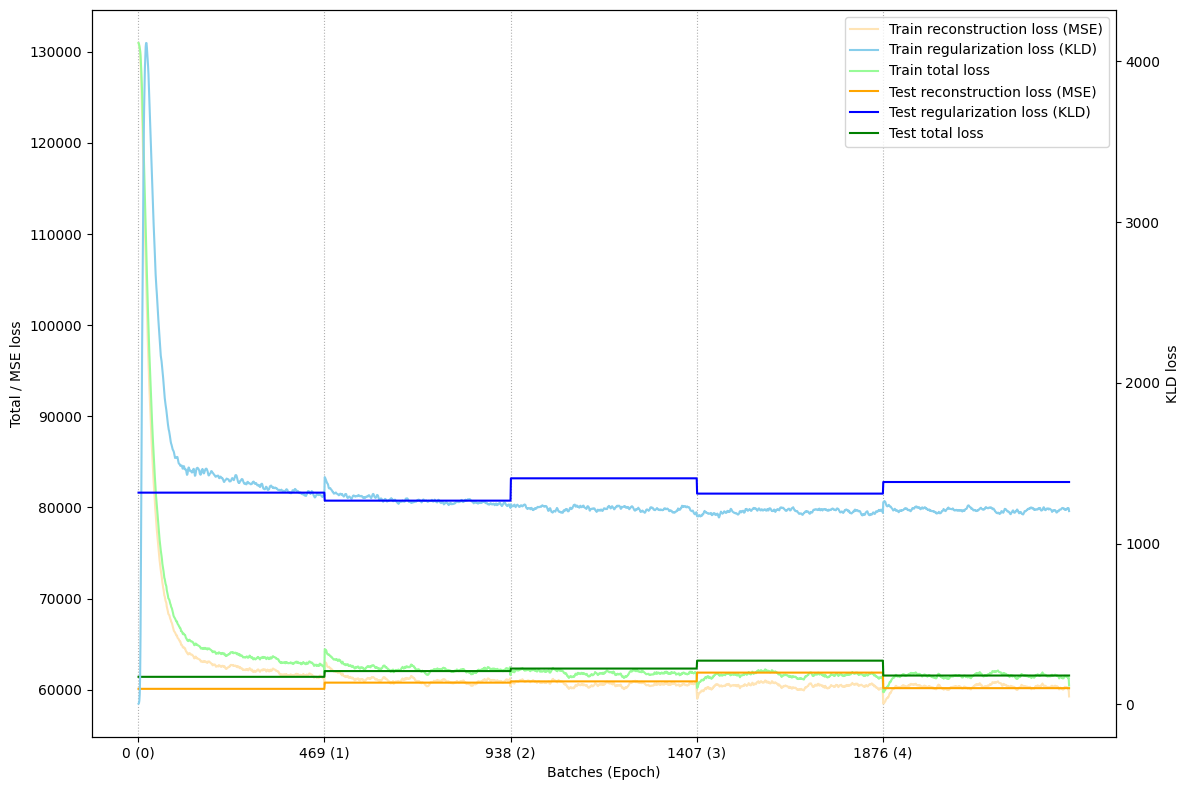


🖼️ Visualizing Reconstructions for Latent Dimension: 16
Original Images


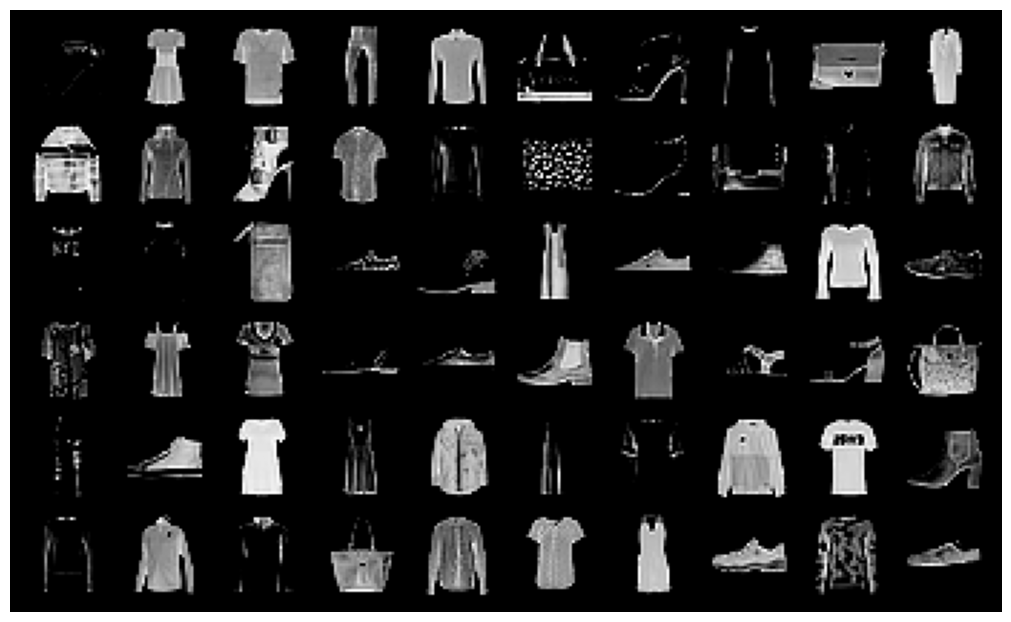

Reconstructed Images


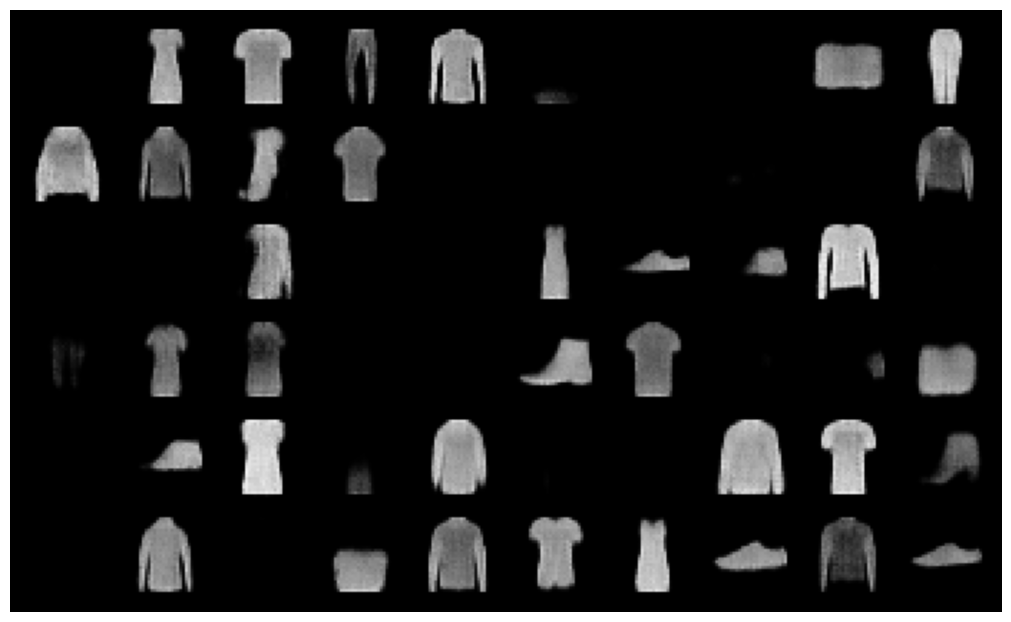


🧪 Training VAE with Latent Dimension: 32


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.41it/s]



📊 Plotting Losses for Latent Dimension: 32


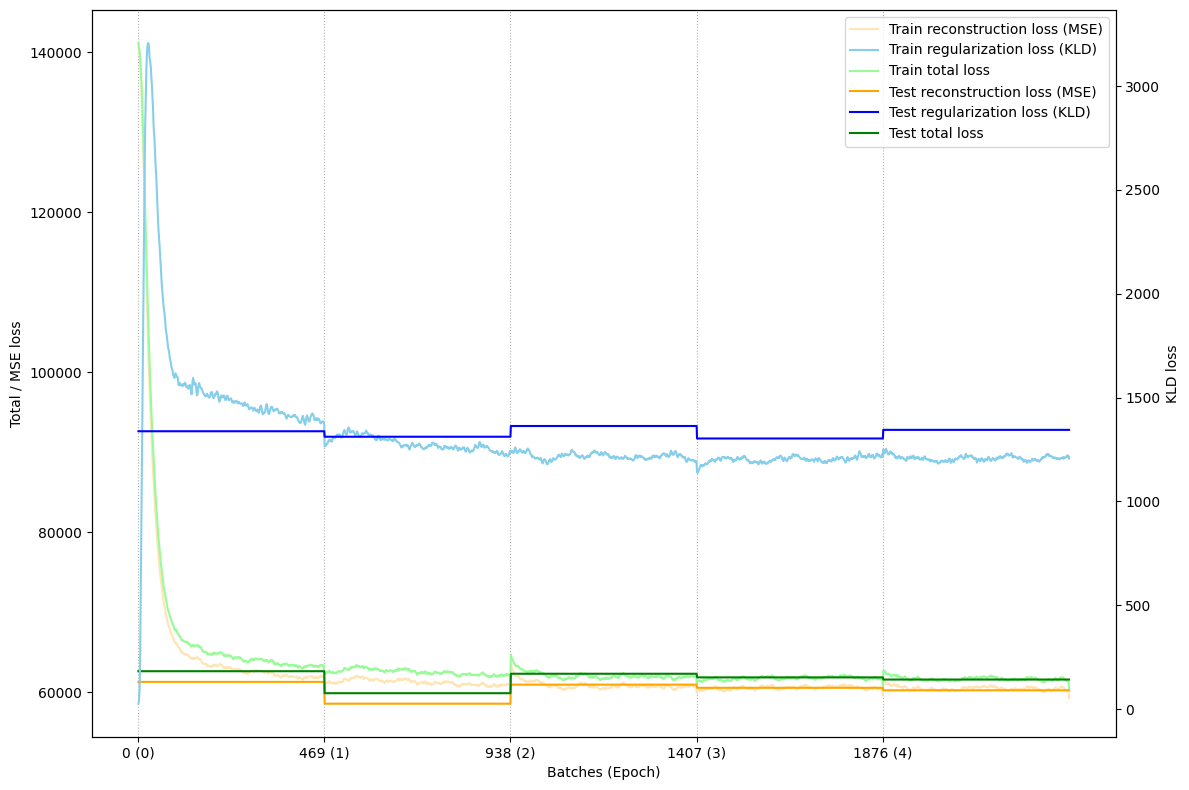


🖼️ Visualizing Reconstructions for Latent Dimension: 32
Original Images


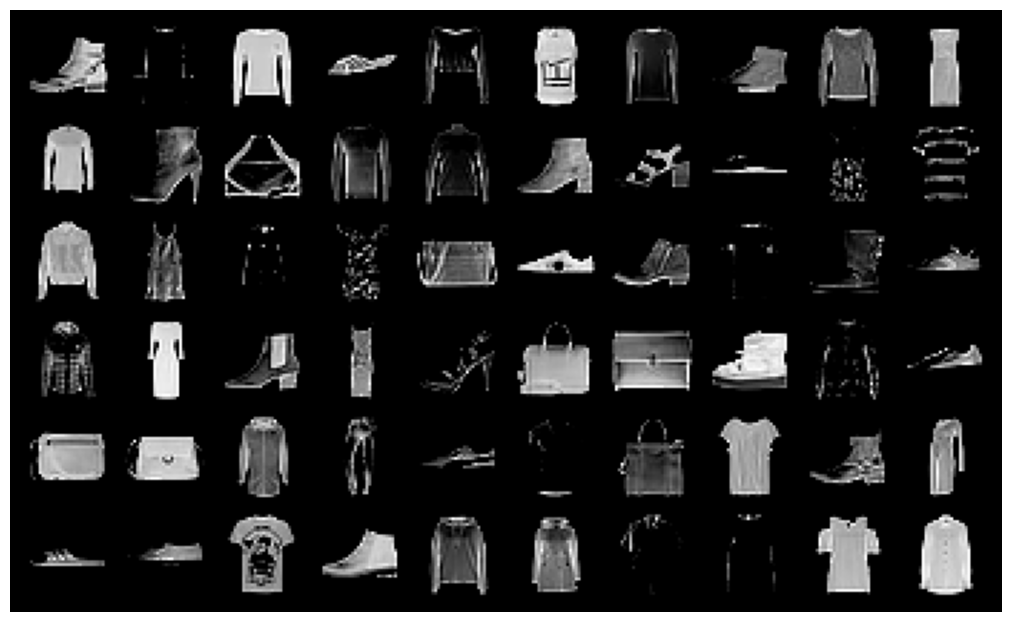

Reconstructed Images


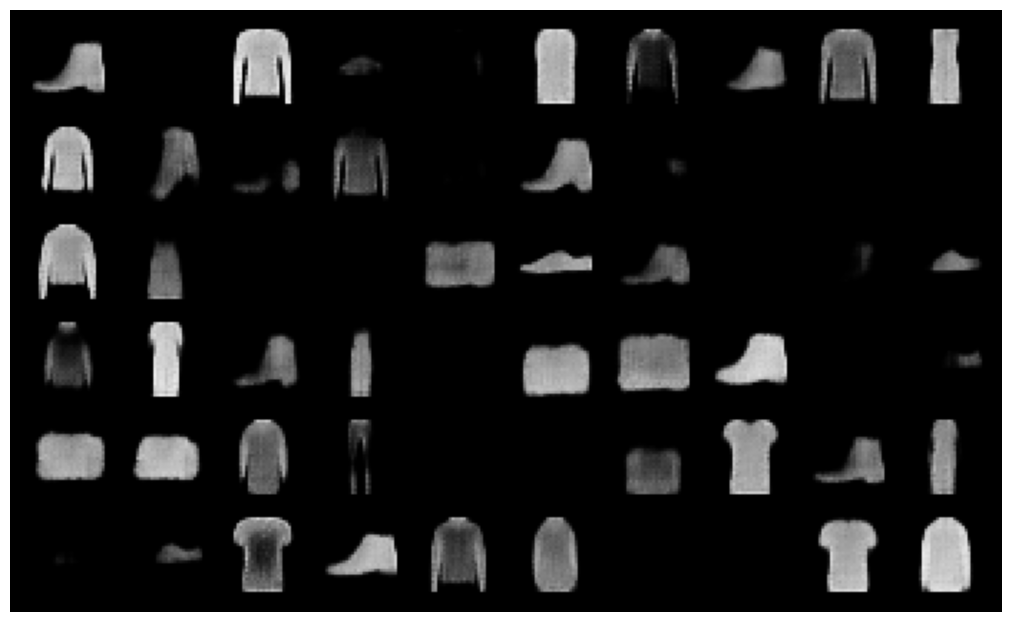

In [18]:
# TODO: Train models with low dim latent space (2d)

# Parameters
latent_dims_list = [2, 4, 8, 16, 32]

# Store results for comparison
results = {}

# Loop through different latent space dimensions
for latent_dim in latent_dims_list:
    print(f"\n🧪 Training VAE with Latent Dimension: {latent_dim}")
    
    # Initialize model and optimizer
    model = VAE(capacity=capacity, latent_dims=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Track losses
    train_total_losses = []
    train_mse_losses = []
    train_kld_losses = []
    
    test_total_losses = []
    test_mse_losses = []
    test_kld_losses = []
    
    # Train and test the model
    for epoch in range(1, epochs + 1):
        epoch_train_total, epoch_train_mse, epoch_train_kld = train(
            model, train_loader, optimizer, epoch, device
        )
        train_total_losses.extend(epoch_train_total)
        train_mse_losses.extend(epoch_train_mse)
        train_kld_losses.extend(epoch_train_kld)
        
        # Test the model (batch-level losses)
        epoch_test_total, epoch_test_mse, epoch_test_kld = test(
            model, test_loader, device
        )
        test_total_losses.extend(epoch_test_total)
        test_mse_losses.extend(epoch_test_mse)
        test_kld_losses.extend(epoch_test_kld)
        
    # Store results
    results[latent_dim] = {
        'model': model,
        'train_total_losses': train_total_losses,
        'train_mse_losses': train_mse_losses,
        'train_kld_losses': train_kld_losses,
        
        'test_total_losses': test_total_losses,
        'test_mse_losses': test_mse_losses,
        'test_kld_losses': test_kld_losses
    }
    
    # Plot losses
    print(f"\n📊 Plotting Losses for Latent Dimension: {latent_dim}")
    plot_losses(
        train_total_losses=train_total_losses,
        train_mse_losses=train_mse_losses,
        train_kld_losses=train_kld_losses,
        
        test_epoch_total_losses=test_total_losses,
        test_epoch_mse_losses=test_mse_losses,
        test_epoch_kld_losses=test_kld_losses
    )
    
    # Visualize Reconstructions
    print(f"\n🖼️ Visualizing Reconstructions for Latent Dimension: {latent_dim}")

    #Parameters for grid display
    images_columns = 10
    images_row = 6

    #Fetch a batch of images from the training loader
    data_iterator = iter(train_loader)
    images, labels = next(data_iterator)
    
    # Show original images
    print("Original Images")
    show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

    #Show reconstruced image
    
    with torch.no_grad():
        images = images.to(device)
        recon_images,mu, logvar = model(images) #Pass the image through VAE

        #Move the reconstruceted images through CPU for the visualization
        recon_images = recon_images.cpu()

        print("Reconstructed Images")
        show_grid(recon_images[0:(images_columns * images_rows)], images_columns, images_rows)


## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code where we set

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO:** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO:** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

Here are two examples.

1x10 traversal of one latent dimension

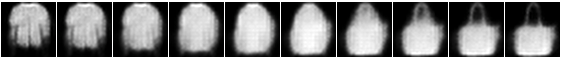

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

In [19]:
# TODO: Plot latent traversals

In [30]:
def visualize_single_dimension(model, latent_dim, dim_index, range_values=(-3, 3), steps=10):
    """
    Visualize the effect of varying a single latent dimension.
    
    Args:
        model: Trained VAE model.
        latent_dim: Latent dimension size.
        dim_index: Index of the latent dimension to vary.
        range_values: Range to vary the dimension.
        steps: Number of steps for traversal.
    """
    model.eval()
    z = torch.zeros((steps, latent_dim)).to(device)  # Create zero latent vectors
    values = torch.linspace(range_values[0], range_values[1], steps)
    
    for i, val in enumerate(values):
        z[i, dim_index] = val  # Vary the specified latent dimension
    
    with torch.no_grad():
        # Manually transform latent vector to match fc_z input size
        if z.size(1) != model.fc_z.in_features:
            z = torch.nn.functional.pad(z, (0, model.fc_z.in_features - z.size(1)))
        
        z = model.fc_z(z)  # Transform latent vector
        z = z.view(-1, model.capacity * 2, 7, 7)  # Reshape appropriately for decoder
        recon_images = model.decoder(z).cpu()
    
    # Visualization
    print(f"\n🔄 Varying Latent Dimension {dim_index}")
    fig, axes = plt.subplots(1, steps, figsize=(15, 2))
    for i in range(steps):
        axes[i].imshow(recon_images[i].squeeze(0).squeeze(0), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{values[i]:.1f}")
    plt.tight_layout()
    plt.show()



🔄 Varying Latent Dimension 0


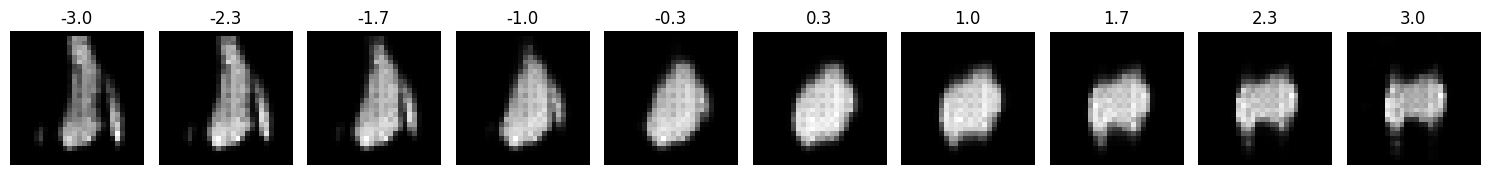

In [32]:
# Example: Single Dimension Traversal with Latent Dim = 8, Varying dim_index = 0
visualize_single_dimension(model, latent_dim=8, dim_index=0)




In [42]:
def visualize_two_dimensions(
    model, 
    latent_dim, 
    dim_index1, 
    dim_index2, 
    range_values=(-3, 3), 
    steps=10, 
    randomize_rest=False
):
    """
    Visualize the effect of varying two latent dimensions.
    
    Args:
        model: Trained VAE model.
        latent_dim: Latent dimension size.
        dim_index1: Index of the first latent dimension to vary.
        dim_index2: Index of the second latent dimension to vary.
        range_values: Range to vary the dimensions.
        steps: Number of steps for traversal.
        randomize_rest: If True, randomize the other dimensions in [-1, 1].
    """
    model.eval()
    
    # Initialize latent vectors
    if randomize_rest:
        z = torch.rand((steps * steps, latent_dim)).to(device) * 2 - 1  # Random values in [-1,1]
    else:
        z = torch.zeros((steps * steps, latent_dim)).to(device)  # Zero initialization
    
    values = torch.linspace(range_values[0], range_values[1], steps)
    
    # Set the two dimensions to vary
    for i, val1 in enumerate(values):
        for j, val2 in enumerate(values):
            z[i * steps + j, dim_index1] = val1
            z[i * steps + j, dim_index2] = val2
    
    with torch.no_grad():
        # Handle mismatch in dimensions
        if z.size(1) != model.fc_z.in_features:
            z = torch.nn.functional.pad(z, (0, model.fc_z.in_features - z.size(1)))
        
        # Pass through the fc_z layer and reshape
        z = model.fc_z(z)
        z = z.view(-1, model.capacity * 2, 7, 7)
        recon_images = model.decoder(z).cpu()
    
    # Visualization
    mode = "Random Initialization" if randomize_rest else "Zero Initialization"
    print(f"\n🔄 Varying Latent Dimensions {dim_index1} and {dim_index2} ({mode})")
    
    fig, axes = plt.subplots(steps, steps, figsize=(10, 10))
    for i in range(steps):
        for j in range(steps):
            axes[i, j].imshow(recon_images[i * steps + j].squeeze(0).squeeze(0), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{values[i]:.1f}, {values[j]:.1f}")
    plt.tight_layout()
    plt.show()



🔄 Varying Latent Dimensions 0 and 1 (Zero Initialization)


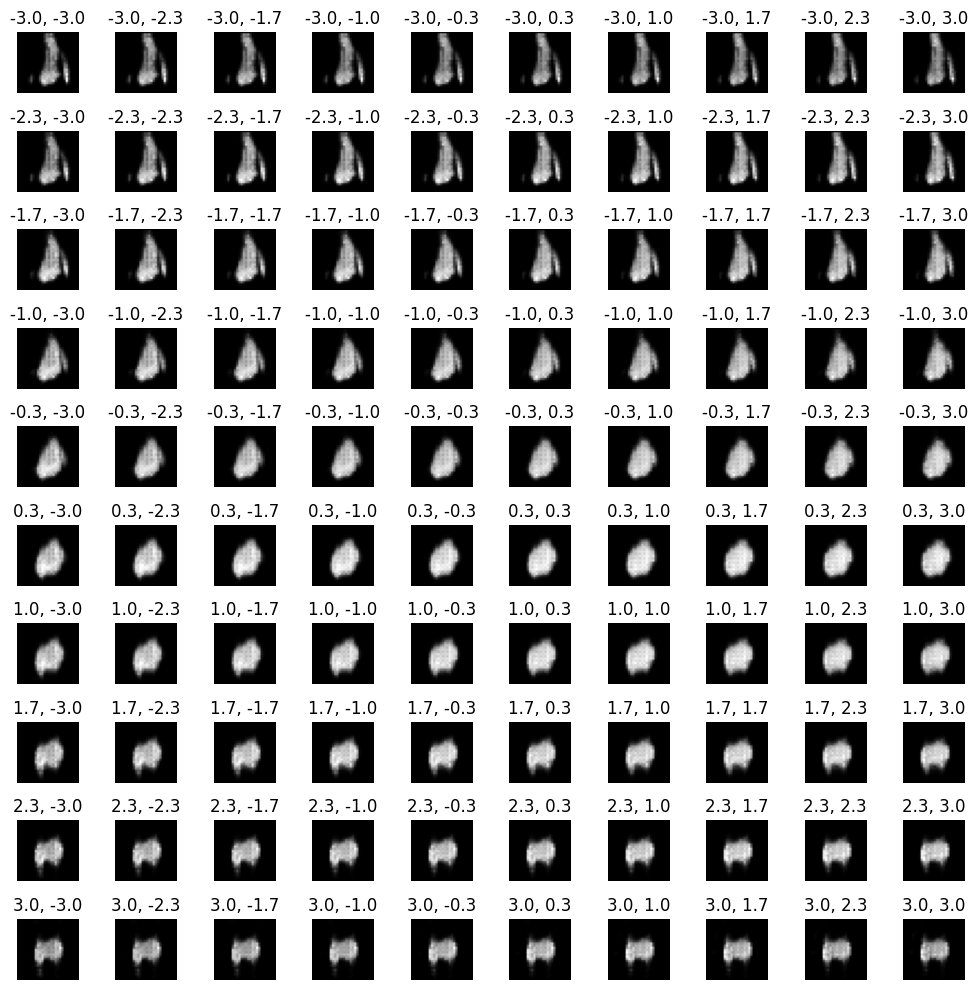

In [43]:
# Two Dimensions Traversal with Zero Initialization
visualize_two_dimensions(model, latent_dim=8, dim_index1=0, dim_index2=1)




🔄 Varying Latent Dimensions 0 and 1 (Random Initialization)


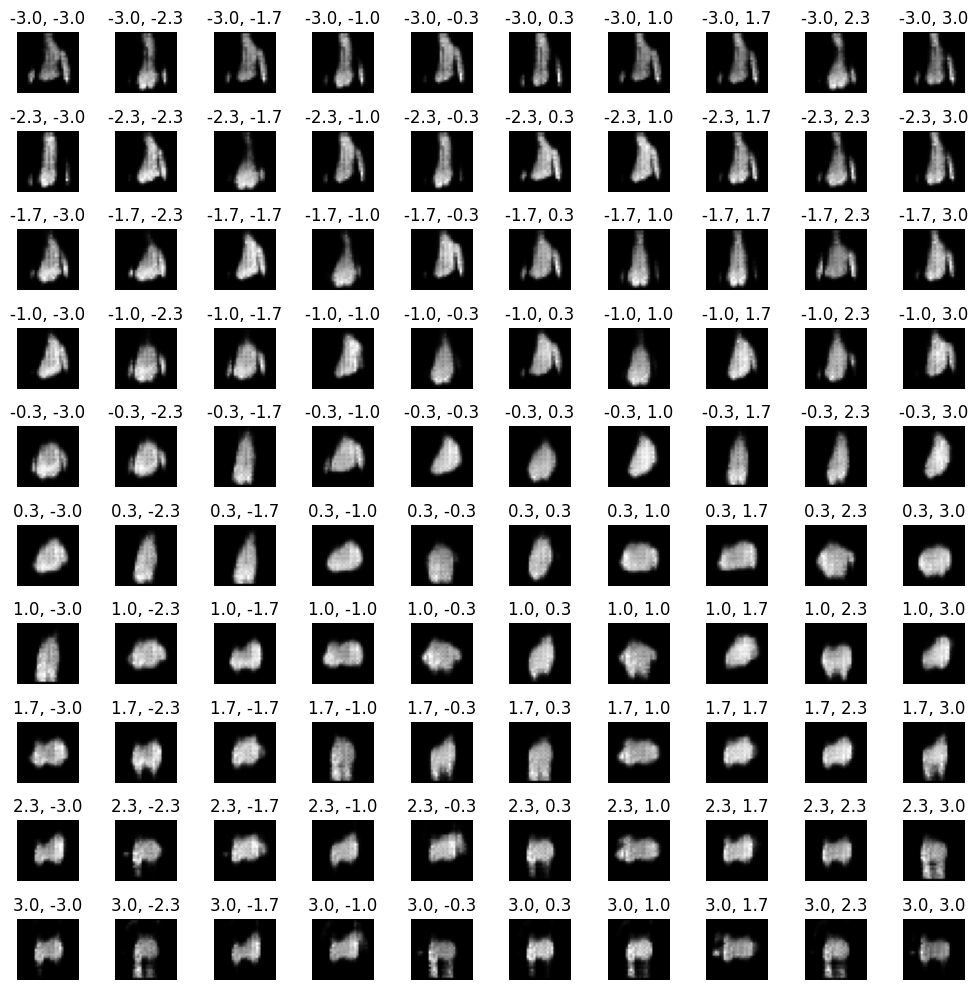

In [44]:
# Two Dimensions Traversal with Random Initialization
visualize_two_dimensions(model, latent_dim=8, dim_index1=0, dim_index2=1, randomize_rest=True)


### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels. 

#### Train 2d latent space model

In [45]:
# TODO: Train model with low dim latent space

In [65]:
# Define a VAE with Latent Dim = 2
latent_dim = 2
model_2d = VAE(capacity=capacity, latent_dims=latent_dim).to(device)
optimizer = optim.Adam(model_2d.parameters(), lr=1e-3)

# Training parameters
epochs = 10  # You can increase this for better results

# Train the model
train_total_losses = []
train_mse_losses = []
train_kld_losses = []

for epoch in range(1, epochs + 1):
    epoch_train_total, epoch_train_mse, epoch_train_kld = train(
        model_2d, train_loader, optimizer, epoch, device
    )
    train_total_losses.extend(epoch_train_total)
    train_mse_losses.extend(epoch_train_mse)
    train_kld_losses.extend(epoch_train_kld)


Training Epoch 10: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]


In [66]:
import numpy as np

def project_to_latent_space(model, data_loader, device):
    """
    Project images from the data_loader into the latent space and collect their labels.
    """
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc="Projecting to Latent Space"):
            data = data.to(device)
            
            # Forward pass through the encoder
            x = model.encoder(data)
            x = x.view(x.size(0), -1)
            mu = model.fc_mu(x)
            
            # Collect latent vectors and labels
            latent_vectors.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())
    
    # Combine all batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_vectors, labels

# Project data into latent space
latent_vectors, labels = project_to_latent_space(model_2d, train_loader, device)


Projecting to Latent Space: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]


#### Visualize classes

In [69]:
def visualize_latent_space_with_overlay(latent_vectors, labels, class_names):
    """
    Visualize 2D latent space with a scatter plot and class label overlay.
    
    Args:
        latent_vectors: Numpy array of shape (N, 2) containing latent space projections.
        labels: Numpy array of class labels corresponding to latent_vectors.
        class_names: List of class names for the dataset labels.
    """
    plt.figure(figsize=(12, 10))
    
    # Create scatter plot
    scatter = plt.scatter(
        latent_vectors[:, 0],
        latent_vectors[:, 1],
        c=labels,
        cmap='tab10',
        alpha=0.7,
        s=5
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Class Labels')
    plt.title('2D Latent Space Visualization with Class Labels and Overlay')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    
    # Overlay text labels at the mean position of each class
    for i in range(10):
        mean_x = np.mean(latent_vectors[labels == i, 0])
        mean_y = np.mean(latent_vectors[labels == i, 1])
        plt.text(mean_x, mean_y, class_names[i], 
                 fontsize=10, color='black',
                )
    
    plt.show()


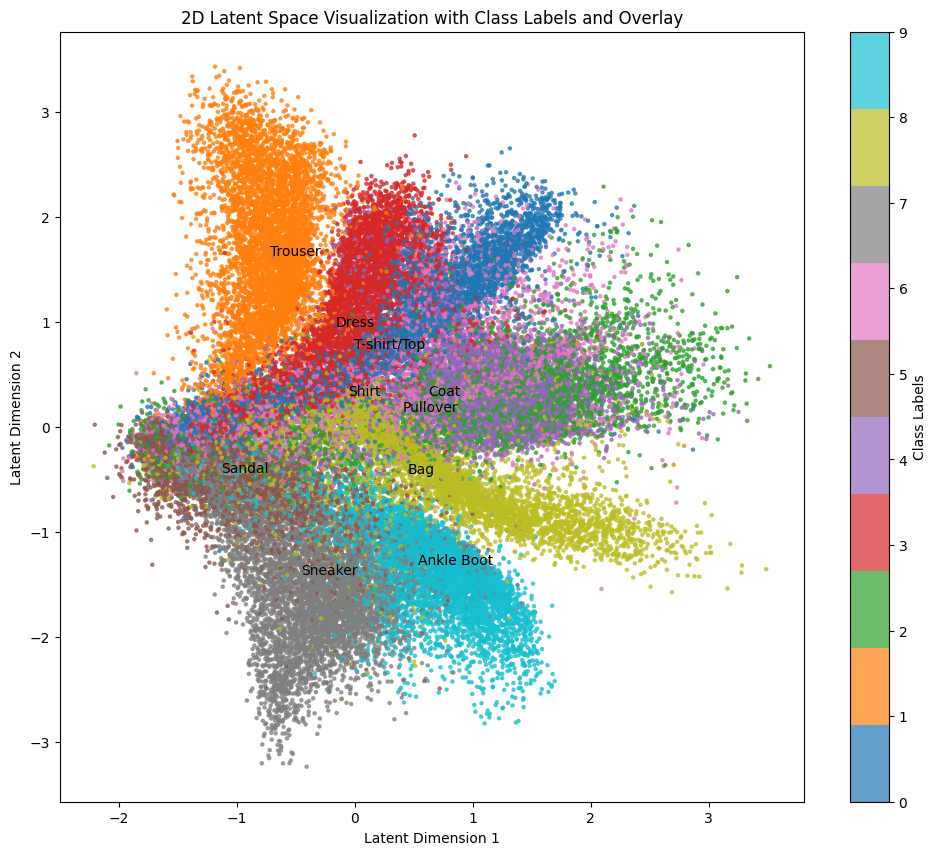

In [70]:
# Define class names for FashionMNIST
class_names = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Visualize with class name overlays
visualize_latent_space_with_overlay(latent_vectors, labels, class_names)


#### Questions

- Do images of the same class cluster in latent space?
  - Yes, the cluster of the same class seems to cluster in the latent space. T-shirts, shorts, coat, and so on seems to have a specific regions whereas sandal, sneakers and so on has other clustering locations. Increasing the capacity can make it even more distinct. 

- Do the data points in latent space look like a normal distribution?
    - The latent space roughly follows a Gaussian distribution but shows some deviations. The overall distribution is dense in the middle and becomes sparse towards edges. 

# Appendix *(Optional)*

Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [ ]:
transform = transforms.Compose([ 
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())